In [1]:
# Samuel Grant 2024

## Read failure events and make plots. 

### Based on PlotFailures.py. Better suited to notebook (so we don't have to load the data each time). 

In [12]:
# External libraries
import numpy as np
import pandas as pd
import awkward as ak
import uproot

# Internal
sys.path.append(os.path.abspath("../PyMacros"))
%run PlotFitUtils.ipynb
import Utils as ut
import PrintUtils as pr

In [ ]:
from statsmodels.stats.proportion import proportion_confint
def WilsonUncertainty(data_, conservative=True):
    # What happens if the number of failures gets close to zero?
    k = np.sum(data_["Failures"])
    N = np.sum(data_["Total"])
    lower, upper = proportion_confint(k, N, method="wilson")
    point = k/N
    if conservative: 
        return abs((upper - point) / 2)
    else:
        return abs((lower - point) / 2)

In [2]:
# Parameters
PEs=10
layers="3"
particle="all"

In [4]:
# Persistent failure info; useful to know. |
inDir="../Txt/MDC2020ae/concatenated"
cut="track_crv12"
failureFilePathTrackCuts = f"{inDir}/failures_concise/failures_concise_all_{PEs}PEs{layers}Layers_track_cuts.csv"
print(f"\n---> Using info file {failureFilePathTrackCuts}.")
failureInfoTrackCuts_ = pd.read_csv(failureFilePathTrackCuts)
print(failureInfoTrackCuts_)
print()

# Results info; useful to know. 
resultsFilePathNoTrackCuts = f"{inDir}/results/results_all_{PEs}PEs{layers}Layers_no_track_cuts.csv"
print(f"\n---> Using info file {resultsFilePathNoTrackCuts}.")
resultsNoTrackCuts_ = pd.read_csv(resultsFilePathNoTrackCuts)
print(resultsNoTrackCuts_)

resultsFilePathTrackCuts = f"{inDir}/results/results_all_{PEs}PEs{layers}Layers_track_cuts.csv"
print(f"\n---> Using info file {resultsFilePathTrackCuts}.")
resultsTrackCuts_ = pd.read_csv(resultsFilePathTrackCuts)
print(resultsTrackCuts_)

ineffNoTrackCuts = np.sum(resultsNoTrackCuts_["Failures"])/np.sum(resultsNoTrackCuts_["Total"])
ineffTrackCuts = np.sum(resultsTrackCuts_["Failures"])/np.sum(resultsTrackCuts_["Total"])

# Start output string 
resultStr = f"""
**********************************
PEs: {PEs}
layers: {layers}/4
particle: {particle}


Total inefficiency...
No track cuts: {np.sum(resultsNoTrackCuts_["Failures"])}/{np.sum(resultsNoTrackCuts_["Total"])} = {ineffNoTrackCuts*100:.5f}%
Track cuts: {np.sum(resultsTrackCuts_["Failures"])}/{np.sum(resultsTrackCuts_["Total"])} = {ineffTrackCuts*100:.5f}%
**********************************
"""

print(resultStr)


---> Using info file ../Txt/MDC2020ae/concatenated/failures_concise/failures_concise_all_10PEs3Layers_track_crv12.csv.
                tag  evtinfo.run  evtinfo.subrun  evtinfo.event
0   001205_00000000         1205             391          32643
1   001205_00000005         1205            7141         345461
2   001205_00000012         1205            3673         465183
3   001205_00000014         1205            8798         192934
4   001205_00000017         1205            8587         493647
5   001205_00000019         1205            3617         250172
6   001205_00000025         1205            7223          28766
7   001205_00000035         1205              35         288996
8   001205_00000037         1205            5538         112688
9   001205_00000050         1205            3258         300543
10  001205_00000062         1205            5440         164658
11  001205_00000069         1205            8751         496244
12  001205_00000072         1205            4131

In [5]:
# Inspect a failure (also in TrackCuts)
# tag="001205_00000020"
run=1205
subrun=299 # 2263
event=79434 # 473431
filename="/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00023/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000000.root" #/exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00069/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000020.root"
with uproot.open(filename) as file:
    print(file)
    array_ = ut.GetData(file)
    print(array_)
    print(array_["evt"]["evtinfo.event"])
    # runCondition = ak.any(array_["evt"]["evtinfo.run"] == run, axis=0)
    # subrunCondition = ak.any(array_["evt"]["evtinfo.subrun"] == subrun, axis=0)
    # eventCondition = ak.any(array_["evt"]["evtinfo.event"] == event, axis=0)
    runCondition = array_["evt"]["evtinfo.run"] == run
    subrunCondition = array_["evt"]["evtinfo.subrun"] == subrun
    eventCondition = array_["evt"]["evtinfo.event"] == event
    array_ = array_[runCondition & subrunCondition & eventCondition] 
    # pr.PrintNEvents(array_, masks_=[")

<ReadOnlyDirectory '/' at 0x7fa4ac500610>
[{evt: {'evtinfo.run': 1205, ...}, crv: {...}, trk: {...}, ...}, ..., {...}]
[331, 379, 759, 891, 1432, 2430, ..., 498161, 499019, 499859, 499895, 499971]


In [6]:
# Internal libraries
sys.path.append(os.path.abspath("../PyMacros"))
import Utils as ut
import PrintUtils as pr
%run PlotFitUtils.ipynb
from Mu2eEAF import ReadData as rd 

In [16]:
'''
Get failure info
For each file, collect the events. 

This takes quite a while (2-3 minutes maybe).
'''
def GetFailures(fileList_, PEs=10, layers="3", particle="all", cut="track_cuts", inDir="../Txt/MDC2020ae/concatenated"):
    
    # Collect failure info
    # inDir="../Txt/MDC2020ae/concatenated"
    failureFilePath = f"{inDir}/failures_concise/failures_concise_{particle}_{PEs}PEs{layers}Layers_{cut}.csv"

    print(f"\n---> Using info file {failureFilePath}.")
    failureInfo_ = pd.read_csv(failureFilePath)

    if failureInfo_.empty:
        print("---> No failure info.")
        dummy_ = {}
        for field, branches_ in ut.allBranchNames_.items():
            dummy_[field] = ak.zip({name: ak.Array([]) for name in branches_})
        return ak.zip(dummy_)

    # Collect file list
    tags_ = list(set(failureInfo_["tag"]))
    
    # Extract the tag from the file name
    def ExtractTag(fileName):
        parts = fileName.split('.')
        if len(parts) > 1:
            return parts[-2]
        return None

    # Filter and sort files based on tags
    fileList_ = sorted(
        [file for file in fileList_ if ExtractTag(file) in tags_]
        , key=lambda file: tags_.index(ExtractTag(file))
    )

    # Bug check
    if len(fileList_) == len(tags_):
        print("\n---> Collected and sorted failure file names.")
    else:
        raise Exception("\n---> len(fileList_) != len(tags_)")

    completedFiles = 0
    totalFiles = len(fileList_)

    print(f"\n---> Iterating through {len(fileList_)} files.\n") 

    # Master array to hold results
    data_ = ak.Array([])
    
    # Iterate through file list.
    for tag, fileName in zip(tags_, fileList_): 
    
        # Find failure events
        thisFailureInfo_ = failureInfo_[failureInfo_["tag"] == tag]
        outputStr = ( 
            f"\n--->\n" 
            f"fileName: {fileName}\n"
            f"tag: {tag}\n"
            f"failures:\n{thisFailureInfo_}\n"
            f"---"
        )
        if False: print(outputStr)
    
        # Read the file
        with uproot.open(fileName) as file: 
            
            # file = (fileName, quiet=True)
            # Get array
            thisData_ = ut.GetData(file)
        
            if False: print(f"\n---> Loaded corresponding data.\n{thisData_}")
                
            if False: print(f"\n---> Applying masks.")
        
            # Extract unique values from DataFrame
            runs_ = set(thisFailureInfo_["evtinfo.run"])
            subruns_ = set(thisFailureInfo_["evtinfo.subrun"])
            events_ = set(thisFailureInfo_["evtinfo.event"])
        
            # Construct masks
            runCondition = ak.any([thisData_["evt"]["evtinfo.run"] == value for value in runs_], axis=0)
            subrunCondition = ak.any([thisData_["evt"]["evtinfo.subrun"] == value for value in subruns_], axis=0)
            eventCondition = ak.any([thisData_["evt"]["evtinfo.event"] == value for value in events_], axis=0)
        
            # Apply masks
            thisData_ = thisData_[runCondition & subrunCondition & eventCondition]
        
            # Append to master array
            if False: print(f"\n---> Appending failures to master array.")
            data_ = ak.concatenate([data_, thisData_], axis=0)

            if False:
                print(thisFailureInfo_)
                ut.PrintNEvents(data_)
    
            completedFiles += 1
            percentComplete = (completedFiles / totalFiles) * 100
            
            print(f"\r---> Processed {fileName} ({percentComplete:.1f}% complete...)", end="") 

    inputEventList = failureInfo_["evtinfo.event"]
    outputEventList = ak.flatten(data_["evt"]["evtinfo.event"], axis=None)

    return data_

In [6]:
# Get file list
fileListPath="../Txt/FileLists/MDC2020aeOnExpData.txt"
def ReadFileList(fileListPath):
  with open(fileListPath, "r") as fileList_:
    lines = fileList_.readlines()
    lines = [line.strip() for line in lines]  # Remove leading/trailing whitespace
  return lines
fileList_=ReadFileList(fileListPath)
print(f"---> {len(fileList_)} files in list.")

---> 96 files in list.


In [19]:
failures_track_cuts_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="no_track_cuts", inDir="../Txt/MDC2020ae/AugustCRVMeeting/FourthPass/concatenated")


---> Using info file ../Txt/MDC2020ae/AugustCRVMeeting/FourthPass/concatenated/failures_concise/failures_concise_all_10PEs3Layers_no_track_cuts.csv.

---> Collected and sorted failure file names.

---> Iterating through 36 files.

---> Processed /exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00078/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000145.root (100.0% complete...)

In [22]:
failures_no_track_cuts_ = failures_track_cuts_

In [18]:
failures_track_cuts_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="track_cuts", inDir="../Txt/MDC2020ae/AugustCRVMeeting/FourthPass/concatenated")


---> Using info file ../Txt/MDC2020ae/AugustCRVMeeting/FourthPass/concatenated/failures_concise/failures_concise_all_10PEs3Layers_track_cuts.csv.
---> No failure info.


In [26]:
failures_track_crv12_ = GetFailures(fileList_, PEs=PEs, layers=layers, particle=particle, cut="track_crv12")


---> Using info file ../Txt/MDC2020ae/concatenated/failures_concise/failures_concise_all_10PEs3Layers_track_crv12.csv.

---> Collected and sorted failure file names.

---> Iterating through 21 files.

---> Processed /exp/mu2e/data/users/sgrant/CRVSim/CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.000/11946817/00/00070/nts.sgrant.CosmicCRYExtractedCatTriggered.MDC2020ae_best_v1_3.001205_00000321.root (100.0% complete...)

[11, -211, 2212, -11]


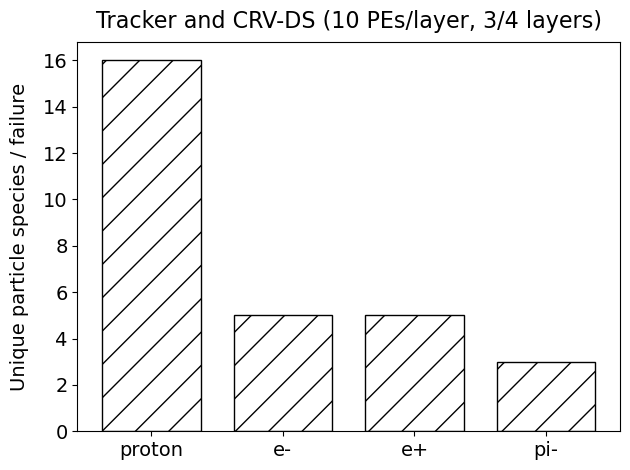

---> Written ../Images/MDC2020ae/Failures/FifthPass/bar_pdgid_track_crv12.png


In [21]:
print(list(set(ak.flatten(failures_track_crv12_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}

BarChart(ak.flatten(failures_track_crv12_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"Tracker and CRV-DS ({PEs} PEs/layer, {layers}/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/FifthPass/bar_pdgid_track_crv12.png", percentage=False)

[11, 2212, -11, -211]


FileNotFoundError: [Errno 2] No such file or directory: '/exp/mu2e/data/users/sgrant/CRVSim/Analyses/Images/MDC2020ae/Failures/FourthPass/bar_pdgid_no_track_cuts.png'

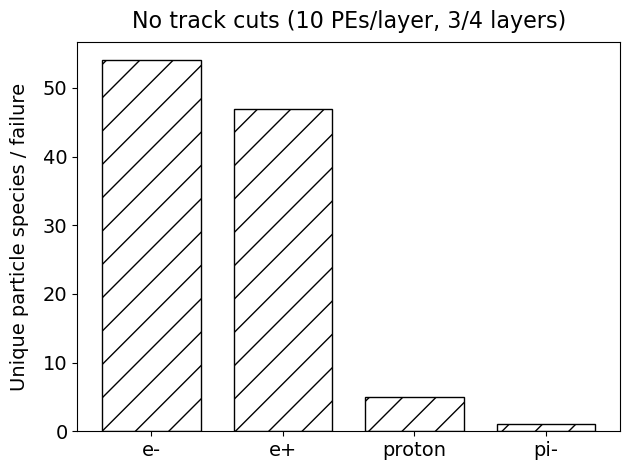

In [25]:
print(list(set(ak.flatten(failures_no_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}

BarChart(ak.flatten(failures_no_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"No track cuts ({PEs} PEs/layer, {layers}/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/FourthPass/bar_pdgid_no_track_cuts.png", percentage=False)

In [9]:
# Plot failure info
print(list(set(ak.flatten(failures_track_crv12_["crv"]["crvcoincsmc.pdgId"], axis=None))))

particle_dict = {
    -13: 'mu+',
    13: 'mu-',
    2212: 'proton',
    -211: 'pi-',
    -11: 'e+',
    11: 'e-',
    # "other": "other"
    # Add more entries as needed
}

SimpleBarChart({"No track cuts" : len(failures_track_crv12_["evt"]["evtinfo.event"]), "Track cuts" : len(failures_track_cuts_["evt"]["evtinfo.event"]) }
         , ylabel="Failures", fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_failures.png")


BarChart(ak.flatten(failures_no_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"No track cuts ({PEs} PEs/layer, {layers}/4 layers)",  ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_pdgid_no_tracks.png", percentage=False)

BarChart(ak.flatten(failures_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)
         , label_dict=particle_dict, title=f"Track cuts ({PEs} PEs/layer, {layers}/4 layers)", ylabel="Unique particle species / failure", fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_pdgid_track_cuts.png", percentage=False)

BarChartOverlay(data_=[ak.flatten(failures_no_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None), ak.flatten(failures_track_cuts_["crv"]["crvcoincsmc.pdgId"], axis=None)]
                , label_dict=particle_dict
                , ylabel="Unique particle species / failure"
                , title=f"{PEs} PEs/layer, {layers}/4 layers"
                , fout=f"../Images/MDC2020ae/Failures/FouthPass/bar_pdgid_track_cuts_overlay.png"
                , percentage=False
                , label_= ["No track cuts", "Track cuts"])


Plot2D(x=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZX_no_track_cuts.png")

Plot2D(x=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(failures_no_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZY_no_track_cuts.png")

Plot2D(x=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fX"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=-8000, ymax=8000
       , title="Track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter X [mm]"
       , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZX_track_cuts.png")

Plot2D(x=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fZ"], axis=None)
       , y=ak.flatten(failures_track_cuts_["trkfit"]["klfit"]["pos"]["fCoordinates"]["fY"], axis=None)
       , nbinsX=100, xmin=-8000, xmax=8000, nbinsY=100, ymin=0, ymax=6000
       , title="No track cuts", xlabel="KKInter Z [mm]", ylabel="KKInter Y [mm]"
       , fout="../Images/MDC2020ae/Failures/ThirdPass/h2_ZY_track_cuts.png")

NameError: name 'failures_no_track_cuts_' is not defined

In [ ]:
# # What is more interesting is those that pass the singles cut, but not the track cut.
# # Although, this good be biased a bit because sometimes the track cuts generate an exception, while the singles do not!
# # Need to ID a file where this doesn't happen. (See ../Scripts/FindGoodFiles.sh)
# # 79 good files, written tags to ../Txt/MDC2020ae/GoodFiles/good_files.csv

# goodFileTags_ = ReadFileList("../Txt/MDC2020ae/GoodFiles/good_files.csv")

# # Make a dataframe for singles and singles_track_cuts using these files. 
# def CollectGoodFiles(goodFileTags_, PEs="10", layer="3", particle="all", cut="singles"):
#     baseDir=f"../Txt/MDC2020ae/failures_concise"
#     data_ = pd.DataFrame()
#     tasks = len(goodFileTags_)
#     completedTasks = 1
#     for i, goodFileTag in enumerate(goodFileTags_):
#         if i == 0: continue # skip header
#         goodFile = f"{baseDir}/{goodFileTag}/failures_concise_{particle}_{PEs}PEs{layer}Layers_{cut}.csv"
#         thisData_ = pd.read_csv(goodFile)
#         # Append data to the main DataFrame without resetting the index
#         if thisData_ is not None: 
#             # Add the tag to the first column
#             thisData_.insert(0, "Tag", goodFileTag)
#             # Concatenate
#             data_ = pd.concat([data_, thisData_], ignore_index=True)
#         completedTasks += 1
#         percentComplete = (completedTasks / tasks) * 100
#         print(f"\r---> Processed {goodFileTag} ({percentComplete:.1f}% complete...)", end="") 
#     return data_

# data_singles_ = CollectGoodFiles(goodFileTags_, PEs=10, cut="singles")
# data_singles_track_cuts_ = CollectGoodFiles(goodFileTags_, PEs=10, cut="singles_track_cuts")

# print(f"\n---> data_singles_:\n{data_singles_}")
# print(f"\n---> data_singles_track_cuts_:\n{data_singles_track_cuts_}")

In [ ]:
# # Now find entries unique to singles_track_cuts_ 
# # Merge DataFrames with an left join to get rows unique to singles_
# # I run the singles filter before the track cuts filter. 
# # This means that some events will pass the singles filter, and then be removed by the track cuts filter.
# # These events are unique to singles. 
# # We can look at the in the event display to see what happens in these cases. 

# # We need events which pass the singles cut but are then removed by the track cuts. 
# # These are actually not present in any of the failure samples, because these just contain failures. 
# # Unfortunately I do not put any marker on the ones removed by the tracker cuts, I just through them out. 

# # Merge
# data_merged_ = pd.merge(data_singles_, data_singles_track_cuts_, how="left", indicator=True)
# # Find unique to singles events
# unique_to_singles_ = data_merged_[data_merged_['_merge'] == 'left_only']
# # Drop the _merge column
# unique_to_singles_ = unique_to_singles_.drop('_merge', axis=1)
# print(unique_to_singles_)

In [ ]:
# Run it again?